In [1]:
import numpy as np 
import pandas as pd 
import warnings
import csv
import langid
from langdetect import detect
import os 
import spacy
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from spacy.lang.ar import Arabic
from sklearn import preprocessing
import seaborn as sns 
from sklearn.model_selection import train_test_split ,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report , confusion_matrix, f1_score
import nltk 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from collections import Counter 
import re
import string
import matplotlib.cm as cm
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

## Combine Data

In [179]:
# # replace with your folder's path
# folder_path = 'C:/Users/rawan/OneDrive/Desktop/NLP/Sentiment-Analysis-for-STC-Arabic-Tweets-1/Labeled Data'

# all_files = os.listdir(folder_path)

# # Filter out non-CSV files
# csv_files = [f for f in all_files if f.endswith('.csv')]

# # Create a list to hold the dataframes
# df_list = []

# for csv in csv_files:
#     file_path = os.path.join(folder_path, csv)
#     try:
#         # Try reading the file using default UTF-8 encoding
#         df = pd.read_csv(file_path)
#         df_list.append(df)
#     except UnicodeDecodeError:
#         try:
#             # If UTF-8 fails, try reading the file using UTF-16 encoding with tab separator
#             df = pd.read_csv(file_path, sep='\t', encoding='utf-16')
#             df_list.append(df)
#         except Exception as e:
#             print(f"Could not read file {csv} because of error: {e}")
#     except Exception as e:
#         print(f"Could not read file {csv} because of error: {e}")

# # Concatenate all data into one DataFrame
# big_df = pd.concat(df_list, ignore_index=True)



In [ ]:
# Save the final result to a new CSV file
# big_df.to_csv(os.path.join(folder_path, 'combined_file.csv'), index=False)

In [110]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 1)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('Labeled Data/combined_file.csv')

In [3]:
df.head(10)

,date,Tweet,label
0,2020-05-27 04:41:01,ياخي ارسلت اكثر مره احد خدمني عندي شريحة مسبقة...,0.0
1,2020-05-27 03:47:08,ابي افعل انترنت الجيل الخامس لمده شهر محدود لش...,-1.0
2,2020-05-27 03:45:29,اخوي شحنت رصيد بفعل خدمه مو راضي طريق ماي اس سي,-1.0
3,2020-05-27 03:07:36,سلام علكيم عام وانتو بخير انا جيت تطبيق ماي اس...,0.0
4,2020-05-27 01:45:20,الله يحيك تم طلبها طريق ماي اس سي يوم ويجيني ا...,1.0
5,2020-05-27 00:58:13,طريق ماي اس سي,0.0
6,2020-05-26 22:49:22,طريقة استخراج بدل فاقد للشريحه ماي اس سي,0.0
7,2020-05-26 18:56:54,اريد التواصل موظف خدمة العملاء بتصل ب بدون اي ...,-1.0
8,2020-05-26 12:55:41,السلام عليكم ، عندي رقم اس سي ماتوصل رسايل اتص...,-1.0
9,2020-05-26 12:13:20,السلام عليكم فقدت شريحتي، وطلبته طريق ماي اس س...,-1.0


In [4]:
df.rename(columns={'label': 'Sentiment'}, inplace=True)


In [5]:
df.head()

,date,Tweet,Sentiment
0,2020-05-27 04:41:01,ياخي ارسلت اكثر مره احد خدمني عندي شريحة مسبقة...,0.0
1,2020-05-27 03:47:08,ابي افعل انترنت الجيل الخامس لمده شهر محدود لش...,-1.0
2,2020-05-27 03:45:29,اخوي شحنت رصيد بفعل خدمه مو راضي طريق ماي اس سي,-1.0
3,2020-05-27 03:07:36,سلام علكيم عام وانتو بخير انا جيت تطبيق ماي اس...,0.0
4,2020-05-27 01:45:20,الله يحيك تم طلبها طريق ماي اس سي يوم ويجيني ا...,1.0


## Dataset Analysis

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1831 entries, 0 to 1830
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       1831 non-null   object 
 1   Tweet      1831 non-null   object 
 2   Sentiment  1822 non-null   float64
dtypes: float64(1), object(2)
memory usage: 43.0+ KB


In [7]:
df.isnull().sum()

date         0
Tweet        0
Sentiment    9
dtype: int64

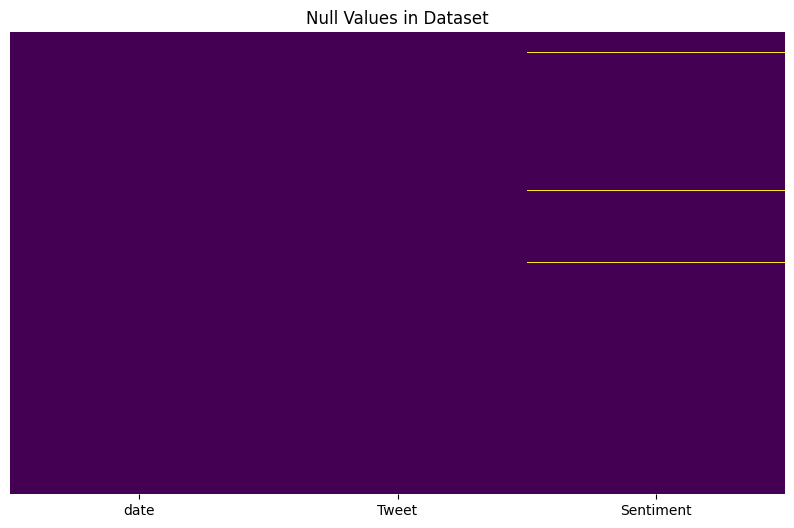

In [8]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Null Values in Dataset')
plt.show()

In [9]:
df = df.dropna(subset=['Sentiment', 'Tweet', 'date'])

In [10]:
df.count()

date         1822
Tweet        1822
Sentiment    1822
dtype: int64

### Drop duplicates and Non-arabic tweet

In [11]:
df = df.drop_duplicates(subset='Tweet', keep='first')

In [12]:
df.count()

date         1719
Tweet        1719
Sentiment    1719
dtype: int64

In [14]:
def filter_farsi_tweets(df):
    # Create a new column to store language detection results
    df['language'] = df['Tweet'].apply(detect)

    # Filter the DataFrame to keep only rows with Arabic language
    filtered_df = df[df['language'] == 'ar']

    # Drop the 'language' column since it's no longer needed
    filtered_df.drop('language', axis=1, inplace=True)

    return filtered_df

In [15]:
filtered_df = filter_farsi_tweets(df)

In [16]:
df = filtered_df


In [17]:
df.count()

date         1555
Tweet        1555
Sentiment    1555
dtype: int64

## PreProccessing

In [18]:
punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ''' + string.punctuation

In [19]:
# Arabic stop words with nltk
nltk.download('stopwords')
stop_words = stopwords.words()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rawan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
arabic_diacritics = re.compile("""
                             ّ    | # Shadda
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

In [21]:
def preprocess(text):
    
    #remove punctuations
    translator = str.maketrans('', '', punctuations)
    text = text.translate(translator)
    
    # remove Tashkeel
    text = re.sub(arabic_diacritics, '', text)
    
    #remove longation
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)

    #remove opreating char
    text =re.sub(r'(.)\1+', r'\1',text)

    #Replace #word with word
    text = re.sub(r'#([^\s]+)', r'\1', text)

    #text = ' '.join(word for word in text.split() if word not in stop_words)

    return text

In [22]:
df['Tweet'] = df['Tweet'].apply(preprocess)
print(df.head(5))

                  date                                              Tweet  \
0  2020-05-27 04:41:01  ياخي ارسلت اكثر مره احد خدمني عندي شريحه مسبقه...   
1  2020-05-27 03:47:08  ابي افعل انترنت الجيل الخامس لمده شهر محدود لش...   
3  2020-05-27 03:07:36  سلام علكيم عام وانتو بخير انا جيت تطبيق ماي اس...   
4  2020-05-27 01:45:20  اله يحيك تم طلبها طريق ماي اس سي يوم ويجيني ال...   
6  2020-05-26 22:49:22            طريقه استخراج بدل فاقد لشريحه ماي اس سي   

   Sentiment  
0        0.0  
1       -1.0  
3        0.0  
4        1.0  
6        0.0  


In [23]:
tokenizer = RegexpTokenizer(r'\w+')
df["Tweet"] = df["Tweet"].apply(tokenizer.tokenize)

In [24]:
df["Tweet"].head(10)

0     [ياخي, ارسلت, اكثر, مره, احد, خدمني, عندي, شري...
1     [ابي, افعل, انترنت, الجيل, الخامس, لمده, شهر, ...
3     [سلام, علكيم, عام, وانتو, بخير, انا, جيت, تطبي...
4     [اله, يحيك, تم, طلبها, طريق, ماي, اس, سي, يوم,...
6      [طريقه, استخراج, بدل, فاقد, لشريحه, ماي, اس, سي]
7     [اريد, التواصل, موظف, خدمه, العملاء, بتصل, ب, ...
8     [السلام, عليكم, عندي, رقم, اس, سي, ماتوصل, رسا...
9     [السلام, عليكم, فقدت, شريحتي, وطلبته, طريق, ما...
10    [السلام, عليكم, الطريقه, لطلب, جهاز, جوال, بنظ...
11    [اقسم, باله, عمركم, سويتوا, شي, كويس, امس, تطب...
Name: Tweet, dtype: object

In [25]:
stopwords_list = stopwords.words('arabic')

In [26]:
stopwords_list

['إذ',
 'إذا',
 'إذما',
 'إذن',
 'أف',
 'أقل',
 'أكثر',
 'ألا',
 'إلا',
 'التي',
 'الذي',
 'الذين',
 'اللاتي',
 'اللائي',
 'اللتان',
 'اللتيا',
 'اللتين',
 'اللذان',
 'اللذين',
 'اللواتي',
 'إلى',
 'إليك',
 'إليكم',
 'إليكما',
 'إليكن',
 'أم',
 'أما',
 'أما',
 'إما',
 'أن',
 'إن',
 'إنا',
 'أنا',
 'أنت',
 'أنتم',
 'أنتما',
 'أنتن',
 'إنما',
 'إنه',
 'أنى',
 'أنى',
 'آه',
 'آها',
 'أو',
 'أولاء',
 'أولئك',
 'أوه',
 'آي',
 'أي',
 'أيها',
 'إي',
 'أين',
 'أين',
 'أينما',
 'إيه',
 'بخ',
 'بس',
 'بعد',
 'بعض',
 'بك',
 'بكم',
 'بكم',
 'بكما',
 'بكن',
 'بل',
 'بلى',
 'بما',
 'بماذا',
 'بمن',
 'بنا',
 'به',
 'بها',
 'بهم',
 'بهما',
 'بهن',
 'بي',
 'بين',
 'بيد',
 'تلك',
 'تلكم',
 'تلكما',
 'ته',
 'تي',
 'تين',
 'تينك',
 'ثم',
 'ثمة',
 'حاشا',
 'حبذا',
 'حتى',
 'حيث',
 'حيثما',
 'حين',
 'خلا',
 'دون',
 'ذا',
 'ذات',
 'ذاك',
 'ذان',
 'ذانك',
 'ذلك',
 'ذلكم',
 'ذلكما',
 'ذلكن',
 'ذه',
 'ذو',
 'ذوا',
 'ذواتا',
 'ذواتي',
 'ذي',
 'ذين',
 'ذينك',
 'ريث',
 'سوف',
 'سوى',
 'شتان',
 'عدا',
 'عسى',
 'عل'

In [27]:
list_To_Str = ' '.join([str(elem) for elem in stopwords_list]) 

In [28]:
list_To_Str

'إذ إذا إذما إذن أف أقل أكثر ألا إلا التي الذي الذين اللاتي اللائي اللتان اللتيا اللتين اللذان اللذين اللواتي إلى إليك إليكم إليكما إليكن أم أما أما إما أن إن إنا أنا أنت أنتم أنتما أنتن إنما إنه أنى أنى آه آها أو أولاء أولئك أوه آي أي أيها إي أين أين أينما إيه بخ بس بعد بعض بك بكم بكم بكما بكن بل بلى بما بماذا بمن بنا به بها بهم بهما بهن بي بين بيد تلك تلكم تلكما ته تي تين تينك ثم ثمة حاشا حبذا حتى حيث حيثما حين خلا دون ذا ذات ذاك ذان ذانك ذلك ذلكم ذلكما ذلكن ذه ذو ذوا ذواتا ذواتي ذي ذين ذينك ريث سوف سوى شتان عدا عسى عل على عليك عليه عما عن عند غير فإذا فإن فلا فمن في فيم فيما فيه فيها قد كأن كأنما كأي كأين كذا كذلك كل كلا كلاهما كلتا كلما كليكما كليهما كم كم كما كي كيت كيف كيفما لا لاسيما لدى لست لستم لستما لستن لسن لسنا لعل لك لكم لكما لكن لكنما لكي لكيلا لم لما لن لنا له لها لهم لهما لهن لو لولا لوما لي لئن ليت ليس ليسا ليست ليستا ليسوا ما ماذا متى مذ مع مما ممن من منه منها منذ مه مهما نحن نحو نعم ها هاتان هاته هاتي هاتين هاك هاهنا هذا هذان هذه هذي هذين هكذا هل هلا هم هما هن هنا هن

In [137]:
#remove stop word
# df["Tweet"] = df["Tweet"].apply(lambda text: [word for word in text if word not in stopwords_list])
# df

In [29]:
y=df['Sentiment']
counter=y.value_counts()

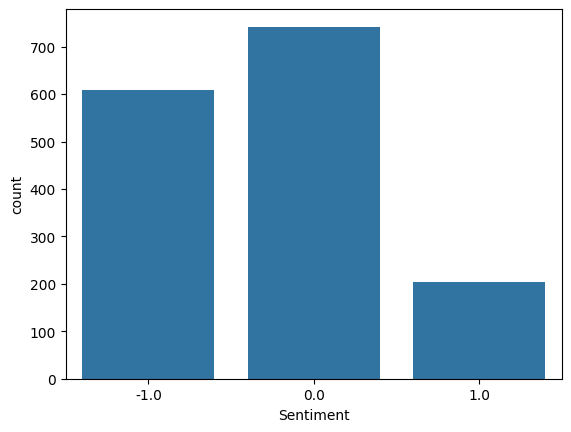

In [30]:
sns.countplot(data= df, x = "Sentiment")
plt.show()

## Feature Extraction

In [31]:
# Initialize the TfidfVectorizer
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(1, 1),
    max_features=10000
)


In [32]:
unigramdataGet = word_vectorizer.fit_transform(df['Tweet'].astype('str'))
unigramdataGet =unigramdataGet.toarray()

In [33]:
vocab = word_vectorizer.get_feature_names_out()

In [34]:
unigramdata_features = pd.DataFrame(np.round(unigramdataGet, 1), columns=vocab)

In [35]:
unigramdata_features[unigramdata_features > 0] = 1

In [36]:
# Print the first few rows of the DataFrame
unigramdata_features

IndentationError: unexpected indent (2515899131.py, line 2)

In [37]:
y=df['Sentiment']
X=unigramdata_features

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


# Balancing The data

## using SMOTE:

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [66]:
smt = SMOTE(sampling_strategy='minority')
print("Before Sampling:", counter)
X_train_sm,y_train_sm= smt.fit_resample(X_train,y_train)

c=y_train_sm.value_counts()
print("After Sampling:", c)

Before Sampling: Sentiment
 0.0    742
-1.0    609
 1.0    204
Name: count, dtype: int64
After Sampling: Sentiment
 1.0    515
 0.0    515
-1.0    422
Name: count, dtype: int64


# Decision Tree (DT)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_train_sm, y_train_sm, test_size=0.30, random_state=333)

In [68]:
print("x_train shape: ", X_train.shape)
print("x_test shape: ", X_test.shape)

print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (1016, 5925)
x_test shape:  (436, 5925)
y_train shape:  (1016,)
y_test shape:  (436,)


In [69]:
Ds=DecisionTreeClassifier(random_state=333)

In [44]:
# Define the hyperparameter grid to search
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy'] }

In [45]:
# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(Ds, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [55]:
# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)


Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}


In [70]:
# Use the best model for predictions
best_classifier = grid_search.best_estimator_
y_pred = best_classifier.predict(X_test)

In [71]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.8302752293577982


In [72]:
# Display classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

        -1.0       0.79      0.79      0.79       125
         0.0       0.76      0.81      0.78       151
         1.0       0.93      0.88      0.91       160

    accuracy                           0.83       436
   macro avg       0.83      0.83      0.83       436
weighted avg       0.83      0.83      0.83       436



# Naive Bayes (NB)

In [159]:
y_train.value_counts()

Sentiment
 0.0    370
 1.0    345
-1.0    304
Name: count, dtype: int64

In [160]:
# Ensure 'Tweet' column contains strings
df['Tweet'] = df['Tweet'].astype(str)

In [161]:
# Initialize the Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB(random_state=333)

In [162]:
# Define the hyperparameter grid
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0],  
}

In [163]:
# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=nb_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1.0, 10.0]}, scoring='accuracy')

In [164]:
# Get the best hyperparameters
best_alpha = grid_search.best_params_['alpha']
print(f'Best alpha: {best_alpha}')

Best alpha: 0.01


In [165]:
# Train the model with the best hyperparameters
nb_classifier = MultinomialNB(alpha=best_alpha)
nb_classifier.fit(X_train, y_train)

# Make predictions
predictions = nb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
classification_report_str = classification_report(y_test, predictions)

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_report_str)

Accuracy: 0.7849
Classification Report:
               precision    recall  f1-score   support

        -1.0       0.76      0.71      0.74       126
         0.0       0.69      0.70      0.69       143
         1.0       0.88      0.91      0.89       168

    accuracy                           0.78       437
   macro avg       0.78      0.77      0.78       437
weighted avg       0.78      0.78      0.78       437



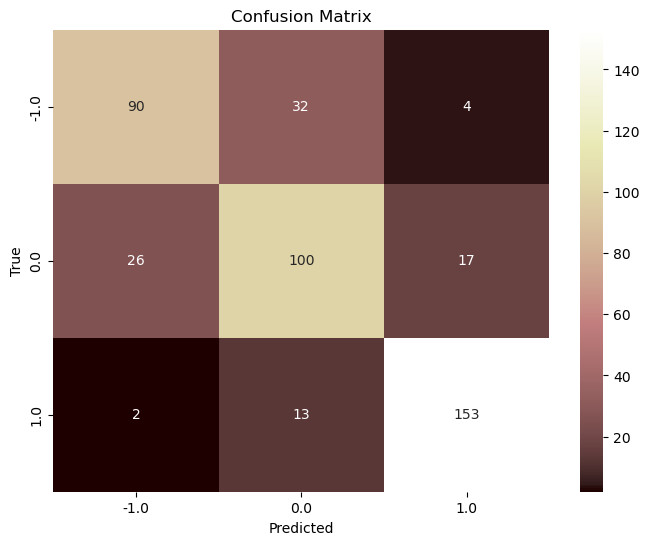

In [166]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='pink', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Support Vector Machine (SVM)

In [292]:
from imblearn import over_sampling
from imblearn.over_sampling import RandomOverSampler
rus=RandomOverSampler(random_state=0)
Xresampled,yresampled=rus.fit_resample(X,y)
print("the value before oversampling: \n ",y.value_counts())
print("the value after oversampling: \n ",yresampled.value_counts())

the value before oversampling: 
  Sentiment
 0.0    739
-1.0    608
 1.0    200
Name: count, dtype: int64
the value after oversampling: 
  Sentiment
 0.0    739
-1.0    739
 1.0    739
Name: count, dtype: int64


In [293]:
X_train, X_test, y_train, y_test = train_test_split(Xresampled, yresampled, test_size=0.30, random_state=333)

In [294]:
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [295]:
rbf = SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_train, y_train)
poly = SVC(kernel='poly', degree=3, C=1).fit(X_train, y_train)

In [296]:
poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)

In [297]:
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial Kernel):  67.72
F1 (Polynomial Kernel):  64.60


In [298]:
rbf_accuracy = accuracy_score(y_test, rbf_pred)
rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (RBF Kernel):  32.88
F1 (RBF Kernel):  16.27


In [299]:
# training a linear SVM classifier 
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train) 
svm_predictions = svm_model_linear.predict(X_test) 
  
# model accuracy for X_test   
accuracy = svm_model_linear.score(X_test, y_test) 
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, svm_predictions) 

In [300]:
svm_model_linear

SVC(C=1, kernel='linear')

In [301]:
cm

array([[169,  37,  16],
       [ 63, 137,  19],
       [  2,  14, 209]], dtype=int64)

In [302]:
accuracy

0.7732732732732732

In [303]:
print(classification_report(y_test,svm_predictions))

              precision    recall  f1-score   support

        -1.0       0.72      0.76      0.74       222
         0.0       0.73      0.63      0.67       219
         1.0       0.86      0.93      0.89       225

    accuracy                           0.77       666
   macro avg       0.77      0.77      0.77       666
weighted avg       0.77      0.77      0.77       666



# One-VS-One (OVO):

In [304]:
# Create an SVM classifier using One-vs-One strategy
svm_model_ovo = OneVsOneClassifier(SVC(kernel='linear'))
svm_model_ovo.fit(X_train, y_train)

OneVsOneClassifier(estimator=SVC(kernel='linear'))

In [305]:
# Predictions
y_pred_ovo = svm_model_ovo.predict(X_test)

In [306]:
# Evaluate accuracy
accuracy_ovo = accuracy_score(y_test, y_pred_ovo)
print("Accuracy (One-vs-One):", accuracy_ovo)

Accuracy (One-vs-One): 0.7687687687687688


# One-Vs-All (OVA):

In [307]:
# Create an SVM classifier using One-vs-All strategy
svm_model_ova = OneVsRestClassifier(SVC(kernel='linear'))
svm_model_ova.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(kernel='linear'))

In [308]:
# Predictions
y_pred_ova = svm_model_ova.predict(X_test)

In [309]:
# Evaluate accuracy
accuracy_ova = accuracy_score(y_test, y_pred_ova)
print("Accuracy (One-vs-All):", accuracy_ova)

Accuracy (One-vs-All): 0.7747747747747747


## SVM Optimization:

In [313]:
tuned_parameters = [{'estimator__kernel': ["linear"], 'estimator__gamma': [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8],
                     'estimator__C': [1, 10, 100, 1000]}]

#scores = ['precision', 'recall']


print("# Tuning hyper-parameters for SVM: " )

clf = GridSearchCV(svm_model_ova, tuned_parameters, cv=5,
                    scoring="accuracy")
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)

# Tuning hyper-parameters for SVM: 


In [ ]:
clf.best_score_

0.7085192697768762

In [ ]:
# Use the best model for predictions
best_classifier = clf.best_estimator_
svm_pred = best_classifier.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, svm_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7688787185354691
